# Feature Extraction

Data preprocessing methods used for the fourth project of the course "Advanced Machine Learning" from ETH.
The task consisted in "DIAGNOSIS OF HEART DISEASES USING ECHOCARDIOGRAPHY VIDEO DATA", for that purpose we followed this paper ftp://ftp.math.ucla.edu/pub/camreport/cam17-26.pdf> in order to get more valuable videos to pass to our pipeline.

In [1]:
import sklearn
import pandas
import skvideo.io
import skvideo.utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

## Reading video frames

In [2]:
def separate_videos(train_target):
    """
    Returns two arrays in a tuple, the first array contains the index of the videos of class 0
    and the second contains the index of the videos of the class 1.
    """
    data_frame = pandas.read_csv(train_target)
    index_class_0 = []
    index_class_1 = []
    
    for row in data_frame.values:
        if row[1] == 0:
            index_class_0.append(row[0])
        else:
            index_class_1.append(row[0])
        
    return (index_class_0, index_class_1)

## Reshaping video frames to column vectors

In [3]:
def reshape_frame_to_column_vector(frame):
    "Reshapes a frame to a column vector"
    #img = frame[:,:,0] # Just select one channel
    column_vector = np.reshape(frame, (10000,1)) # Frames with 100 * 100 pixels, therefore vector with 10000 rows and one column.
    return column_vector

In [4]:
def compute_X_from_video(video):
    "Computer the matrix X with all the frames as column vectors in the matrix"
    video_gray = skvideo.utils.rgb2gray(video)
    X = [] # Vector with all the frames as column vectors
    for frame in video_gray:
        X.append(reshape_frame_to_column_vector(frame))
        
    X = np.array(X)
    X.shape = (video_gray.shape[0],10000) # Force the correct shape
    X = X.transpose() # Array should be of dimension (D*N) where N is number of frame
    
    return X

## Implement Non-negative Matrix Factorization

After computing $NMF$, in $W_{1}$ and $W_{2}$ we have the frames corresponding to the end-systole and end-diastole.

In [5]:
def compute_NMF(X):
    "Decompose the matrix in X=W*H"
    model = NMF(n_components=2)
    W = model.fit_transform(X)
    H = model.components_
    
    return (W, H)


## Plot the NMF Coefficients  against each frame

In [6]:
def plot_coefficients(H,i):
    "Plot the coefficients curves of the H matrix"
    plt.figure(i)
    plt.title("Video {}".format(i))
    plt.plot(list(range(1, len(H[0,:])+1)), H[0,:], 'b',
             list(range(1, len(H[1,:])+1)), H[1,:], 'r')
    plt.legend(('Coefficients of W1', 'Coefficients of W2'), loc='upper right')
    

In [7]:
def show_graph(video_path,i):
    "Show the grap of the coeffecients curves of the vide_path in the figure i"
    video = skvideo.io.vread(video_path)
    X = compute_X_from_video(video)
    W,H = compute_NMF(X)
    plot_coefficients(H,i)

## Decompose Video

In [8]:
def decompose_video(video_path):
    "Returns a 3-tuple with X, W, H"
    video = skvideo.io.vread(video_path)
    X = compute_X_from_video(video)
    W, H = compute_NMF(X)
    
    return (X, W, H)

After decomposing the videos we can generate artificial images of the end-sytole and end-diastole.

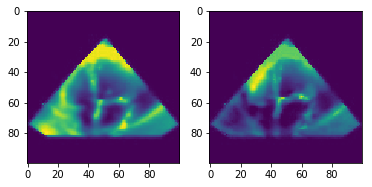

In [19]:
X, W, H = decompose_video("./test/1.avi")
plt.subplot(1,2,1)
plt.imshow(np.reshape(W[:, 0], (100,100)))

plt.subplot(1,2,2)
plt.imshow(np.reshape(W[:, 1], (100,100)))

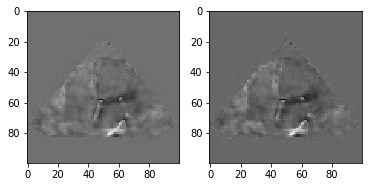

In [25]:
E = X-W @ H

plt.subplot(1,2,1)
plt.imshow(np.reshape(E[:, 0], (100,100)), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(np.reshape(E[:, 1], (100,100)), cmap='gray')

## Generate $E= X -WH$

According to the paper the E matrix captures information on muscle and valve movement.

In [9]:
def generate_difference_video(X, W, H, path):
    "Creates a video from the E matrix and saves the video in path"
    E = X - W @ H
    new_video = []
    
    for column in range(E.shape[1]):
        new_video.append(np.reshape(E[:, column],(100,100)))
        
    new_video = np.array(new_video)
    skvideo.io.vwrite(path, new_video)

##  Generate $X' = WH$

According to the paper in the $X'$ we see the heart volume change between end-systole and end-diastole
in the endmembers.

In [10]:
def generate_NMF_video(W, H, path):
    "Creates a video from the matrix X' and saves the video in path"
    NMF = W @ H
    new_video = []
    
    for column in range(NMF.shape[1]):
        new_video.append(np.reshape(NMF[:, column],(100,100)))
        
    new_video = np.array(new_video)
    skvideo.io.vwrite(path, new_video)

## Possible method of selecting outliers

The basic idea is that in the curves of the coefficients in which we can't find a period, should be discarded.
This can also be seen more explicit creating an scatter plot.

For example the in "1.avi", we cannot apreciate the different parts of the heart and its coefficients yield the 
followint plot.

In [11]:
def plot_coefficients_scatter(H,i):
    "Plot the coefficients in a scatter plot"
    plt.figure(i)
    plt.scatter(H[0,:], H[1,:])

In [12]:
def plot_both(H, i):
    plt.subplot(1,2,1)
    
    plt.title("Video {}".format(i))
    plt.plot(list(range(1, len(H[0,:])+1)), H[0,:], 'b',
             list(range(1, len(H[1,:])+1)), H[1,:], 'r')
    
    plt.subplot(1,2,2)
    plt.scatter(H[0,:], H[1,:])
    
    

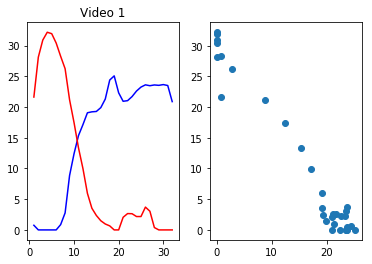

In [13]:
X1,W1,H1 = decompose_video("./train/1.avi")
plot_both(H1, 1)